In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
from eegatscale.models import LinearHeadBENDR
from eegatscale.transforms import Standardize
from scipy.stats import ttest_ind
import torch
import tqdm

from captum.concept import TCAV, Concept
from captum.concept._utils.common import concepts_to_str
from concept_classifier import TCAVClassifier
import warnings
warnings.filterwarnings("ignore")

from dataset_utils import Experiment

In [2]:
concepts_dir = '/scratch/s194101/concepts/'

print(list(os.listdir(concepts_dir)))



['left_right_concepts_MMIDB_Gamma_new_T0', 'random_tuh_alpha_rh', 'random_mmidb_alpha_no_baseline_lh', 'random_left_concept_MMIDB_Alpha_sanity_check_1000_with_sigma', 'random_mmidb_alpha_no_baseline_with_sigma', 'sanity_check_concepts_MMIDB_alpha_no_baseline', 'random_right_concept_MMIDB_Alpha_sanity_check_1000_no_baseline', 'random_mmidb_alpha_baseline_T0_rh', 'random_mmidb_alpha_lh', 'mmidb_notebook_concepts_alpha', 'mmidb_alpha_baseline_rh_whole', 'sanity_check_concepts_MMIDB_alpha_baseline_with_sigma', 'random_right_concept_MMIDB_Alpha_sanity_check', 'mmidb_alpha_baseline_T2_whole', 'sanity_check_concepts_MMIDB_alpha_baseline', 'TUH_clean_alpha_subtract_Truesigma_Trueabs_100.0_142440_131124', 'random_mmidb_alpha_rh', 'random_right_concept_MMIDB_Alpha_sanity_check_1000', 'mmidb_alpha_baseline_lh_whole', 'TUSZ', 'random_mmidb_alpha_baseline_T0_lh', 'random_tuh_alpha_1000', 'random_mmidb_alpha_no_baseline', 'mmidb_alpha_baseline_T1_whole', 'random_tuh_alpha_lh', 'random_mmidb_alpha_no

## load model

In [3]:
out_features = 2
# encoder_path = "/scratch/agjma/checkpoints/tuh-noica-standardize-epoch=9-step=68317-val_loss=0.26.ckpt"
encoder_path = "/scratch/s194101/finetune_logs_all/mmidb_noica_noica_5.0_splits10_repeat2/version_19/checkpoints/epoch=7-step=8120.ckpt"

model = LinearHeadBENDR(encoder_path, encoder_h=512, in_features=19, out_features=out_features)
state_dict = torch.load(encoder_path, map_location=torch.device('cpu'))["state_dict"]
model.load_state_dict(state_dict)
model.eval()
print("model loaded")

Initialized mask embedding and position encoder from  /scratch/s194101/finetune_logs_all/mmidb_noica_noica_5.0_splits10_repeat2/version_19/checkpoints/epoch=7-step=8120.ckpt
model loaded


In [4]:
# target_data = "mmidb_alpha_baseline_T1_whole"
# target_data = "random_left_concept_MMIDB_Alpha_sanity_check_1000"
target_data = "random_left_concept_MMIDB_Alpha_sanity_check"
# target_data = "random_mmidb_gamma_baseline_T1"
# target_data = "random_left_concept_MMIDB_Alpha_sanity_check_1000_no_baseline"
# target_data = "random_left_concept_MMIDB_Alpha_sanity_check_1000_with_sigma"
# target_data = "random_left_concept_MMIDB_Alpha"
# random_concept = "random_mmidb_alpha_new"
# random_concept = "random_mmidb_alpha_no_baseline_with_sigma"
# random_concept = "random_mmidb_alpha_no_baseline"
# random_concept = "random_mmidb_alpha_baseline_T0"
# random_concept = "random_mmidb_gamma_no_baseline"
random_concept = "random_tuh_all_1000"
# random_concept = "random_tuh_alpha_1000"
# random_concept = "random_tuh_alpha_whole"
# random_concept = "random_tuh_gamma_1000"

concept_dir_names = [
    "random_left_concept_MMIDB_Alpha_sanity_check",
    "random_right_concept_MMIDB_Alpha_sanity_check",
#     # "random_left_concept_MMIDB_Alpha_sanity_check_1000",
#     # "random_right_concept_MMIDB_Alpha_sanity_check_1000",
#     # "mmidb_alpha_baseline_lh_whole",
#     # "mmidb_alpha_baseline_rh_whole",
#     # "mmidb_notebook_concepts_alpha/Alpha_lh",
#     # "mmidb_notebook_concepts_alpha/Alpha_rh",
#     # "mmidb_notebook_concepts_alpha_gamma/Alpha_lh",
#     # "mmidb_notebook_concepts_alpha_gamma/Alpha_rh",
#     # "random_left_concept_MMIDB_Alpha_sanity_check_1000_no_baseline",
#     # "random_right_concept_MMIDB_Alpha_sanity_check_1000_no_baseline",
    # "random_left_concept_MMIDB_Alpha_sanity_check_1000_with_sigma",
    # "random_right_concept_MMIDB_Alpha_sanity_check_1000_with_sigma",
# #     "random_left_concept_MMIDB_Alpha",
# #     "random_right_concept_MMIDB_Alpha",
    "random_mmidb_alpha_lh",
# # #     # "left_right_concepts_MMIDB_alpha_new/Alpha_lh",
# # #     # "left_right_concepts_MMIDB_alpha_new_T0/Alpha_lh",
# # #     # "random_tuh_alpha_lh",
# # #     # "random_mmidb_alpha_baseline_with_sigma_lh",
# # #     # "random_mmidb_alpha_no_baseline_T0_lh",
# # #     # "random_mmidb_gamma_no_baseline_lh",
    "random_mmidb_alpha_rh",
# # #     # "left_right_concepts_MMIDB_alpha_new/Alpha_rh",
# # #     # "left_right_concepts_MMIDB_alpha_new_T0/Alpha_rh",
# # #     # "random_tuh_alpha_rh",
# # #     # "random_mmidb_alpha_baseline_with_sigma_rh",
# # #     # "random_mmidb_alpha_no_baseline_T0_rh",
# # #     # "random_mmidb_gamma_no_baseline_rh",
    ]

# T0 concepts
# concept_dir_names = [
    # "random_left_concept_MMIDB_Alpha_sanity_check",
    # "random_right_concept_MMIDB_Alpha_sanity_check",
    # "random_mmidb_alpha_baseline_T0_lh",
    # "random_mmidb_alpha_baseline_T0_rh",
#     # "random_tuh_alpha_lh",
#     # "random_tuh_alpha_rh",
# ]

# gamma
# concept_dir_names = [
#     "random_mmidb_gamma_baseline_T1",
#     "random_mmidb_gamma_baseline_T2",
#     "random_mmidb_gamma_baseline_lh",
#     "random_mmidb_gamma_baseline_rh",
# ]

# with concepts that are not subsets (whole)

# concept_dir_names = [
#     "mmidb_alpha_baseline_T1_whole",
#     "mmidb_alpha_baseline_T2_whole",
#     "mmidb_alpha_baseline_lh_whole",
#     "mmidb_alpha_baseline_rh_whole",
# ]


# mmidb no baseline
# concept_dir_names = [
#     "sanity_check_concepts_MMIDB_alpha_no_baseline/Alpha_Premotor Cortex-lh",
#     "sanity_check_concepts_MMIDB_alpha_no_baseline/Alpha_Premotor Cortex-rh",
#     "sanity_check_concepts_MMIDB_alpha_no_baseline/Alpha_Somatosensory and Motor Cortex-lh",
#     "sanity_check_concepts_MMIDB_alpha_no_baseline/Alpha_Somatosensory and Motor Cortex-rh",
#     "sanity_check_concepts_MMIDB_alpha_no_baseline/Alpha_Early Visual Cortex-lh",
#     "sanity_check_concepts_MMIDB_alpha_no_baseline/Alpha_Early Visual Cortex-rh",
#     "sanity_check_concepts_MMIDB_alpha_no_baseline/Alpha_Primary Visual Cortex (V1)-lh",
#     "sanity_check_concepts_MMIDB_alpha_no_baseline/Alpha_Primary Visual Cortex (V1)-rh",
#     "sanity_check_concepts_MMIDB_alpha_no_baseline/Alpha_Dorsal Stream Visual Cortex-lh",
#     "sanity_check_concepts_MMIDB_alpha_no_baseline/Alpha_Dorsal Stream Visual Cortex-rh",
#     ]

# mmidb baseline
# concept_dir_names = [
#     "sanity_check_concepts_MMIDB_alpha_baseline/Alpha_Premotor Cortex-lh",
#     "sanity_check_concepts_MMIDB_alpha_baseline/Alpha_Premotor Cortex-rh",
#     "sanity_check_concepts_MMIDB_alpha_baseline/Alpha_Somatosensory and Motor Cortex-lh",
#     "sanity_check_concepts_MMIDB_alpha_baseline/Alpha_Somatosensory and Motor Cortex-rh",
#     "sanity_check_concepts_MMIDB_alpha_baseline/Alpha_Early Visual Cortex-lh",
#     "sanity_check_concepts_MMIDB_alpha_baseline/Alpha_Early Visual Cortex-rh",
#     "sanity_check_concepts_MMIDB_alpha_baseline/Alpha_Primary Visual Cortex (V1)-lh",
#     "sanity_check_concepts_MMIDB_alpha_baseline/Alpha_Primary Visual Cortex (V1)-rh",
#     "sanity_check_concepts_MMIDB_alpha_baseline/Alpha_Dorsal Stream Visual Cortex-lh",
#     "sanity_check_concepts_MMIDB_alpha_baseline/Alpha_Dorsal Stream Visual Cortex-rh",
#     ]

# MMIDB no baseline no sigma only T0
# concept_dir_names = [
#     "sanity_check_concepts_MMIDB_alpha_no_baseline_T0/Alpha_Premotor Cortex-lh",
#     "sanity_check_concepts_MMIDB_alpha_no_baseline_T0/Alpha_Premotor Cortex-rh",
#     "sanity_check_concepts_MMIDB_alpha_no_baseline_T0/Alpha_Somatosensory and Motor Cortex-lh",
#     "sanity_check_concepts_MMIDB_alpha_no_baseline_T0/Alpha_Somatosensory and Motor Cortex-rh",
#     "sanity_check_concepts_MMIDB_alpha_no_baseline_T0/Alpha_Early Visual Cortex-lh",
#     "sanity_check_concepts_MMIDB_alpha_no_baseline_T0/Alpha_Early Visual Cortex-rh",
#     "sanity_check_concepts_MMIDB_alpha_no_baseline_T0/Alpha_Primary Visual Cortex (V1)-lh",
#     "sanity_check_concepts_MMIDB_alpha_no_baseline_T0/Alpha_Primary Visual Cortex (V1)-rh",
#     "sanity_check_concepts_MMIDB_alpha_no_baseline_T0/Alpha_Dorsal Stream Visual Cortex-lh",
#     "sanity_check_concepts_MMIDB_alpha_no_baseline_T0/Alpha_Dorsal Stream Visual Cortex-rh",
#     ]

# tuh concepts
# concept_dir_names = [
#     "TUH_clean_alpha_subtract_Truesigma_Trueabs_100.0_142440_131124/Alpha_Premotor Cortex-lh",
#     "TUH_clean_alpha_subtract_Truesigma_Trueabs_100.0_142440_131124/Alpha_Premotor Cortex-rh",
#     "TUH_clean_alpha_subtract_Truesigma_Trueabs_100.0_142440_131124/Alpha_Somatosensory and Motor Cortex-lh",
#     "TUH_clean_alpha_subtract_Truesigma_Trueabs_100.0_142440_131124/Alpha_Somatosensory and Motor Cortex-rh",
#     "TUH_clean_alpha_subtract_Truesigma_Trueabs_100.0_142440_131124/Alpha_Early Visual Cortex-lh",
#     "TUH_clean_alpha_subtract_Truesigma_Trueabs_100.0_142440_131124/Alpha_Early Visual Cortex-rh",
#     "TUH_clean_alpha_subtract_Truesigma_Trueabs_100.0_142440_131124/Alpha_Primary Visual Cortex (V1)-lh",
#     "TUH_clean_alpha_subtract_Truesigma_Trueabs_100.0_142440_131124/Alpha_Primary Visual Cortex (V1)-rh",
#     "TUH_clean_alpha_subtract_Truesigma_Trueabs_100.0_142440_131124/Alpha_Dorsal Stream Visual Cortex-lh",
#     "TUH_clean_alpha_subtract_Truesigma_Trueabs_100.0_142440_131124/Alpha_Dorsal Stream Visual Cortex-rh",
#     ]






# target_data = concept_dir_names[0]
experiments = []
idx = 0
n_concept_samples = 50
for concept_dir_name in concept_dir_names:
    exp = Experiment(model,
                    target_data,
                    concepts_dir,
                    [
                    concept_dir_name, # this is where you add extra concepts, (in the square brackets)
                    random_concept,
                    ],
                    verbose=True,
                    n_concept_samples=n_concept_samples,
                    n_runs=100,
                    internal_concept_idx=idx)
    experiments.append(exp)
    idx += 1000

Loaded dataset random_left_concept_MMIDB_Alpha_sanity_check with 200 samples
Loaded dataset random_tuh_all_1000 with 1000 samples
Loaded input dataset random_left_concept_MMIDB_Alpha_sanity_check with 200 samples
Loaded dataset random_right_concept_MMIDB_Alpha_sanity_check with 200 samples
Loaded dataset random_tuh_all_1000 with 1000 samples
Loaded input dataset random_left_concept_MMIDB_Alpha_sanity_check with 200 samples
Loaded dataset random_mmidb_alpha_lh with 200 samples
Loaded dataset random_tuh_all_1000 with 1000 samples
Loaded input dataset random_left_concept_MMIDB_Alpha_sanity_check with 200 samples
Loaded dataset random_mmidb_alpha_rh with 200 samples
Loaded dataset random_tuh_all_1000 with 1000 samples
Loaded input dataset random_left_concept_MMIDB_Alpha_sanity_check with 200 samples


In [5]:
plt_name = f"{target_data}-" + "-".join(concept_dir_names[1:]) + f"-{random_concept}" + f"-{n_concept_samples}"
# plt_name

# substitute / with _
# plt_name = plt_name.replace("/", "_")

# plt_name = f"tuh_anatomical_concepts_alpha_all_baseline_vs_{target_data}_concepts50_runs100"
# plt_name = f"tuh_anatomical_concepts_alpha_all_baseline_vs_{target_data}_concepts50_runs100"
# plt_name = f"mmidb_anatomical_concepts_alpha_all_no_baseline_T0_vs_{target_data}_concepts50_runs100"
# plt_name = "left_fist_prediction_alpha_baseline_with_sigma_vs_random_tuh_alpha"

In [32]:
experiments[0].internal_concept_idx

200

In [33]:
for concept_name, concepts in experiments[0].concepts.items():
    print(concept_name)
    print(concepts)
    break

random_left_concept_MMIDB_Alpha_sanity_check
[Concept(0, 'random_left_concept_MMIDB_Alpha_sanity_check_000'), Concept(1, 'random_left_concept_MMIDB_Alpha_sanity_check_001'), Concept(2, 'random_left_concept_MMIDB_Alpha_sanity_check_002'), Concept(3, 'random_left_concept_MMIDB_Alpha_sanity_check_003'), Concept(4, 'random_left_concept_MMIDB_Alpha_sanity_check_004'), Concept(5, 'random_left_concept_MMIDB_Alpha_sanity_check_005'), Concept(6, 'random_left_concept_MMIDB_Alpha_sanity_check_006'), Concept(7, 'random_left_concept_MMIDB_Alpha_sanity_check_007'), Concept(8, 'random_left_concept_MMIDB_Alpha_sanity_check_008'), Concept(9, 'random_left_concept_MMIDB_Alpha_sanity_check_009'), Concept(10, 'random_left_concept_MMIDB_Alpha_sanity_check_010'), Concept(11, 'random_left_concept_MMIDB_Alpha_sanity_check_011'), Concept(12, 'random_left_concept_MMIDB_Alpha_sanity_check_012'), Concept(13, 'random_left_concept_MMIDB_Alpha_sanity_check_013'), Concept(14, 'random_left_concept_MMIDB_Alpha_sanity_ch

In [34]:
experiments[0].concept_names[0]

'random_left_concept_MMIDB_Alpha_sanity_check'

In [35]:
# for concept_name, concepts in experiments[0].concepts.items():
#     print(concept_name)
#     print(concepts)
#     for concept in concepts:
#         print(next(iter(concept.data_iter)).shape)
#         print(next(iter(concept.data_iter))[0,0])

# experiments[0].concepts.values()

In [36]:
for experiment in experiments:
    save_path = f"/home/s194101/Bachelors-explainability/{experiment.inputs_name}_{experiment.concept_names[0].split('/')[-1]}.pkl" if "/" in experiment.concept_names[0] else f"/home/s194101/Bachelors-explainability/{experiment.inputs_name}_{experiment.concept_names[0]}.pkl"
    # print(save_path)
    print(experiment.inputs_name)
    

random_left_concept_MMIDB_Alpha_sanity_check
random_left_concept_MMIDB_Alpha_sanity_check
random_left_concept_MMIDB_Alpha_sanity_check
random_left_concept_MMIDB_Alpha_sanity_check


In [37]:
layers = ["encoder", "enc_augment", "summarizer", "extended_classifier", "clf"]

def run_tcav(experiment:Experiment, layers:list):
    if "/" in experiment.concept_names[0]:
        save_path = f"/scratch/s194101/temp/cav/{experiment.concept_names[0].split('/')[-1]}/"
    else:
        save_path = f"/scratch/s194101/temp/cav/{experiment.concept_names[0]}/"
    tcav = TCAV(model, layers, model_id="BendrModel", classifier=TCAVClassifier(), save_path=save_path)
    # tcav = TCAV(model, layers, save_path=save_path)
    tcav_scores = tcav.interpret(inputs=experiment.inputs, experimental_sets=experiment.experimental_sets, target=0)
    tcav_scores = dict(tcav_scores)

    save_path = f"/home/s194101/Bachelors-explainability/{experiment.inputs_name}_{experiment.concept_names[0].split('/')[-1]}.pkl" if "/" in experiment.concept_names[0] else f"/home/s194101/Bachelors-explainability/{experiment.inputs_name}_{experiment.concept_names[0]}.pkl"
    # print(save_path)
    with open(save_path, "wb") as f:
        pickle.dump(
            {"tcav_scores": tcav_scores,
             "experimental_sets": experiment.experimental_sets,},f)
    return tcav_scores
        

In [38]:
tcav = TCAV(model, layers, model_id="BendrModel", classifier=TCAVClassifier(), save_path="/scratch/s194101/temp/cav_test/")
tmp_scores = tcav.interpret(inputs=experiments[0].inputs, experimental_sets=[experiments[0].experimental_sets[0], experiments[1].experimental_sets[0]], target=0)


In [39]:
experiments[1].experimental_sets[0]

[Concept(1000, 'random_right_concept_MMIDB_Alpha_sanity_check_000'),
 Concept(1100, 'random_tuh_all_1000_000')]

In [40]:
experiments[0].experimental_sets[0]

[Concept(0, 'random_left_concept_MMIDB_Alpha_sanity_check_000'),
 Concept(100, 'random_tuh_all_1000_000')]

In [41]:
for exp in experiments:
    run_tcav(exp, layers)
    print(exp.inputs_name, exp.concept_names[0])

random_left_concept_MMIDB_Alpha_sanity_check random_left_concept_MMIDB_Alpha_sanity_check
random_left_concept_MMIDB_Alpha_sanity_check random_right_concept_MMIDB_Alpha_sanity_check
random_left_concept_MMIDB_Alpha_sanity_check random_mmidb_alpha_lh
random_left_concept_MMIDB_Alpha_sanity_check random_mmidb_alpha_rh


In [6]:
all_experimental_sets = []
all_tcav_scores = []

for i, exp in enumerate(experiments):
    # where the files are saved
    file_path = f"/home/s194101/Bachelors-explainability/{exp.inputs_name}_{exp.concept_names[0].split('/')[-1]}.pkl" if "/" in exp.concept_names[0] else f"/home/s194101/Bachelors-explainability/{exp.inputs_name}_{exp.concept_names[0]}.pkl"
    with open(file_path, "rb") as f:
        data = pickle.load(f)
        all_tcav_scores.append(data["tcav_scores"])
        all_experimental_sets.append(data["experimental_sets"])

In [16]:
from plot_utils import assemble_scores, plot_tcav_scores
import plotly.graph_objects as go
import plotly.express as px
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind, mannwhitneyu



def plot_tcav_scores_plotly(all_experimental_sets, all_tcav_scores, concept_names=None, title="", score_type="sign_count", alpha=0.05, only_significant=True,
                     with_error=True, plt_name="plot", file_type="svg"):
    tcav_score0 = next(iter(all_tcav_scores[0].values()))
    layers = list(tcav_score0.keys())
    scores_mean = {layer: [] for layer in layers}
    scores_std = {layer: [] for layer in layers}
    stars = {layer: [] for layer in layers}
    concept_short_names = []
    for experimental_sets, tcav_scores in zip(all_experimental_sets, all_tcav_scores):
        concept_short_codes = [int(str(concept.id)[:5]) for concept in experimental_sets[0]]
        concept_short_names_next = [concept.name[:-4] for concept in experimental_sets[0]]
        concept_short_names.append(concept_short_names_next[0])

        for layer in layers:
            pos_scores = assemble_scores(tcav_scores, experimental_sets, 0, layer, score_type)
            neg_scores = assemble_scores(tcav_scores, experimental_sets, 1, layer, score_type)
            # t-test
            _, pval = ttest_ind(pos_scores, neg_scores)
            # mann whitney u rank test
            _, pval_whit = mannwhitneyu(pos_scores, neg_scores)

            print(f"pval: {pval}, pval_whit: {pval_whit}")
            pval = pval_whit
            # print(pval)
            # Bonferroni correction
            m = 2
            alpha = alpha / m
            # Get non-significant and significant scores
            # not_significant = np.mean(pos_scores) < np.mean(neg_scores) or pval >= alpha
            not_significant = pval >= alpha
            stars[layer].append(~not_significant)
            if not_significant and only_significant:
                scores_mean[layer].append(0.0)
                scores_std[layer].append(0.0)
            else:
                scores_mean[layer].append(np.mean(pos_scores))
                scores_std[layer].append(np.std(pos_scores))

    if not concept_names:
        scores_mean_df = pd.DataFrame(data=scores_mean, index=concept_short_names)
        scores_std_df = pd.DataFrame(data=scores_std, index=concept_short_names)
    else:
        scores_mean_df = pd.DataFrame(data=scores_mean, index=concept_names)
        scores_std_df = pd.DataFrame(data=scores_std, index=concept_names)

    stars = {layer: ["*" if star else "" for star in stars[layer]] for layer in layers}

    fig = go.Figure()
    for layer in layers:
        fig.add_trace(go.Bar(
            x=concept_short_names,
            y=scores_mean[layer],
            # error_y=dict(type='data', array=scores_std[layer]),
            name=layer,
            text=stars[layer],
            textposition='outside',
            # fontsize
            # text color
        ))

    fig.update_layout(
        width=1700,
        height=720,
        # barmode='group',
        title=title,
        yaxis_title='TCAV score',
        xaxis_title='Concept',
        font=dict(
            size=18,
        ),

    )
    # print(stars)
    # change x tick labels
    fig.update_xaxes(tickvals=[i for i in range(len(concept_short_names))])
    fig.update_xaxes(ticktext=concept_names)
    # update ticktext font size
    fig.update_xaxes(tickfont=dict(size=24))

    # set y-axis to always go from 0 to 1
    fig.update_yaxes(range=[0, 1])
    
    # set xticks angle
    fig.update_xaxes(tickangle=0)
    

    # tight layout
    fig.update_layout(margin=dict(l=20, r=20, t=60, b=20))

    # save figure
    fig.write_image(f"figures/{plt_name}_plotly.{file_type}")
    fig.show()




pval: 5.772420306342627e-05, pval_whit: 5.575586984434819e-06
pval: 2.044415044275489e-09, pval_whit: 2.4060681492798148e-09
pval: 3.422001433596394e-29, pval_whit: 4.8531605930526037e-23
pval: 2.997643631397731e-15, pval_whit: 2.2322965870522193e-13
pval: 6.144969430430456e-66, pval_whit: 2.2351404568528277e-35
pval: 3.763942662196914e-224, pval_whit: 1.5653474818091618e-39
pval: 1.2032218374869165e-264, pval_whit: 2.714147061215191e-41
pval: 1.8373844308804068e-186, pval_whit: 5.159661971463339e-41
pval: 2.031837603817325e-111, pval_whit: 8.949323994160817e-42
pval: 0.0, pval_whit: 3.5216158823946e-45
pval: 1.9742212573580644e-28, pval_whit: 4.7935865982490674e-23
pval: 2.2639919719330104e-27, pval_whit: 1.4113483473387362e-22
pval: 7.403505235879394e-07, pval_whit: 1.8152663031673376e-06
pval: 8.404851356505848e-07, pval_whit: 1.627725958171554e-06
pval: 2.2603640627734593e-19, pval_whit: 2.8267741843605536e-16
pval: 6.704690139581683e-64, pval_whit: 1.2922739593362761e-33
pval: 7.4

pval: 5.772420306342627e-05, pval_whit: 5.575586984434819e-06
pval: 2.044415044275489e-09, pval_whit: 2.4060681492798148e-09
pval: 3.422001433596394e-29, pval_whit: 4.8531605930526037e-23
pval: 2.997643631397731e-15, pval_whit: 2.2322965870522193e-13
pval: 6.144969430430456e-66, pval_whit: 2.2351404568528277e-35
pval: 3.763942662196914e-224, pval_whit: 1.5653474818091618e-39
pval: 1.2032218374869165e-264, pval_whit: 2.714147061215191e-41
pval: 1.8373844308804068e-186, pval_whit: 5.159661971463339e-41
pval: 2.031837603817325e-111, pval_whit: 8.949323994160817e-42
pval: 0.0, pval_whit: 3.5216158823946e-45
pval: 1.9742212573580644e-28, pval_whit: 4.7935865982490674e-23
pval: 2.2639919719330104e-27, pval_whit: 1.4113483473387362e-22
pval: 7.403505235879394e-07, pval_whit: 1.8152663031673376e-06
pval: 8.404851356505848e-07, pval_whit: 1.627725958171554e-06
pval: 2.2603640627734593e-19, pval_whit: 2.8267741843605536e-16
pval: 6.704690139581683e-64, pval_whit: 1.2922739593362761e-33
pval: 7.4

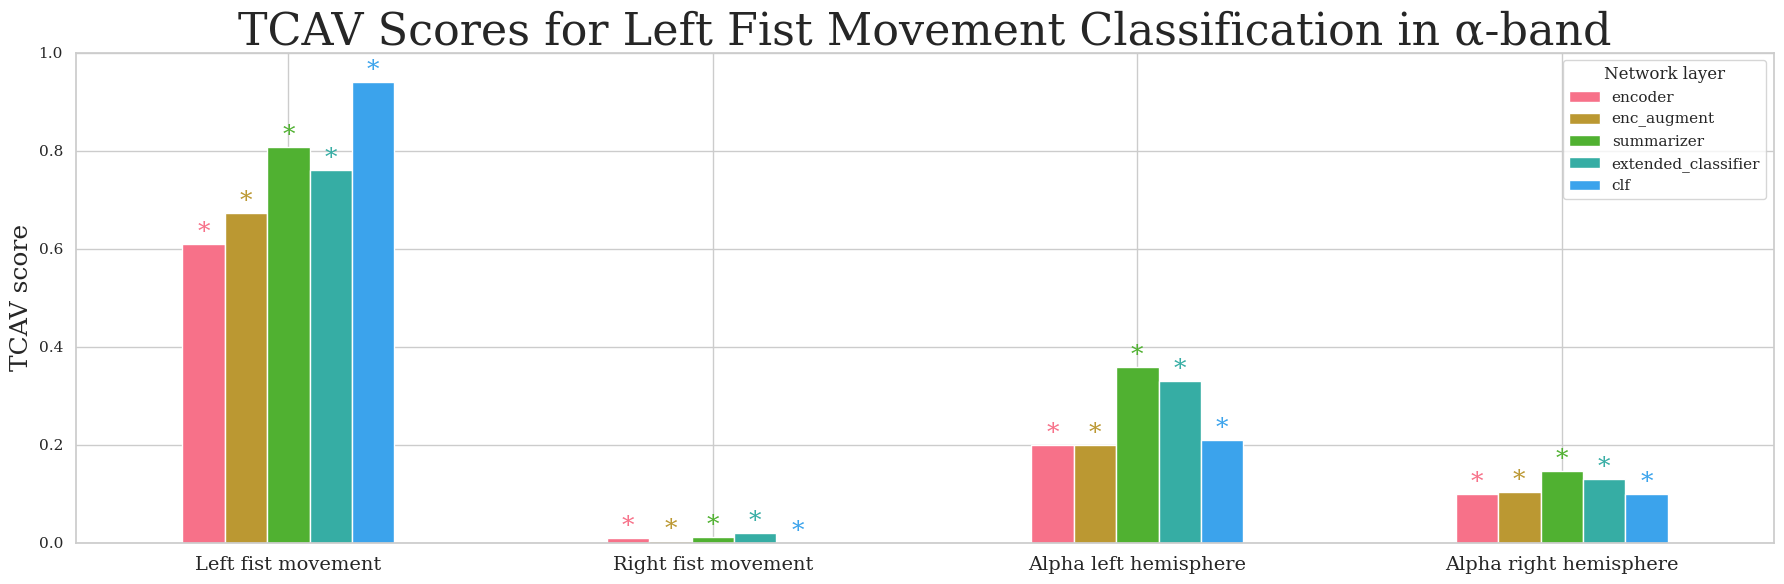

In [17]:
concept_names = ["Left fist movement", "Right fist movement", "Alpha left hemisphere", "Alpha right hemisphere"]
# concept_names = ["Left fist movement", "Right fist movement", "Gamma left hemisphere", "Gamma right hemisphere"]
# concept_names = ["Premotor Cortex-lh", "Premotor Cortex-rh", "Somatosensory and Motor Cortex-lh", "Somatosensory and Motor Cortex-rh"]
# concept_names = ["Early Visual Cortex-lh", "Early Visual Cortex-rh", "Primary Visual Cortex-lh", "Primary Visual Cortex-rh"]
# concept_names = ["Premotor <br> Cortex-lh", "Premotor <br> Cortex-rh", "Somatosensory and <br> Motor Cortex-lh", "Somatosensory and <br> Motor Cortex-rh", "Early Visual <br> Cortex-lh", "Early Visual  Cortex-rh", "Primary Visual <br> Cortex (V1)-lh", "Primary Visual <br> Cortex (V1)-rh", "Dorsal Stream <br> Visual Cortex-lh", "Dorsal Stream <br> Visual Cortex-lh"]



# title = "TCAV Scores for Left Fist Movement Classification with Anatomy Concepts in \u03B1-band"
# title = r"TCAV Scores for Left Fist Movement Classification in \u03B1-band"
title = "TCAV Scores for Left Fist Movement Classification in \u03B1-band"


# plt_name = "left_fist_prediction_alpha_vs_random_tuh_alpha"
# plt_name = "left_fist_prediction_alpha_baseline_with_sigma_vs_random_tuh_alpha"
# plt_name = "left_fist_prediction_anatomical_alpha_premotor_somatosensory_vs_random_mmidb_alpha_no_baseline"
# plt_name = "left_fist_prediction_anatomical_alpha_visual"

plot_tcav_scores_plotly(all_experimental_sets, all_tcav_scores, concept_names=concept_names, title=title, score_type="sign_count", alpha=0.05, only_significant=False, with_error=False, plt_name=plt_name, file_type="png")

concept_names = [concept_name.replace("<br>", "\n") for concept_name in concept_names]
scores_mean_df, scores_std_df = plot_tcav_scores(all_experimental_sets, all_tcav_scores, concept_names=concept_names, title=title, score_type="sign_count", alpha=0.05, only_significant=False, with_error=False, plt_name=plt_name, file_type="png")
# scores_mean_df

# scores_std_df   

In [45]:
# all_tcav_scores[2]
assemble_scores(all_tcav_scores[1], all_experimental_sets[1], 0, "encoder", "sign_count")

array([0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.05, 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.2 , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.03, 0.02, 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.02, 0.  , 0.  , 0.  , 0.  , 0.04, 0.03, 0.  , 0.01,
       0.  , 0.  , 0.01, 0.  , 0.  , 0.  , 0.  , 0.  , 0.02, 0.  , 0.  ,
       0.  , 0.  , 0.02, 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.03, 0.01,
       0.  , 0.  , 0.13, 0.  , 0.  , 0.  , 0.  , 0.  , 0.14, 0.  , 0.  ,
       0.  , 0.25, 0.  , 0.02, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  ], dtype=float32)